### EDA (Exploratory Data Analysis)

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/drive/My Drive/Machine_Learning_Lab/HR-Employee-Attrition.csv')

In [38]:
# Basic info
print(df.info())
print(df['Attrition'].value_counts())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

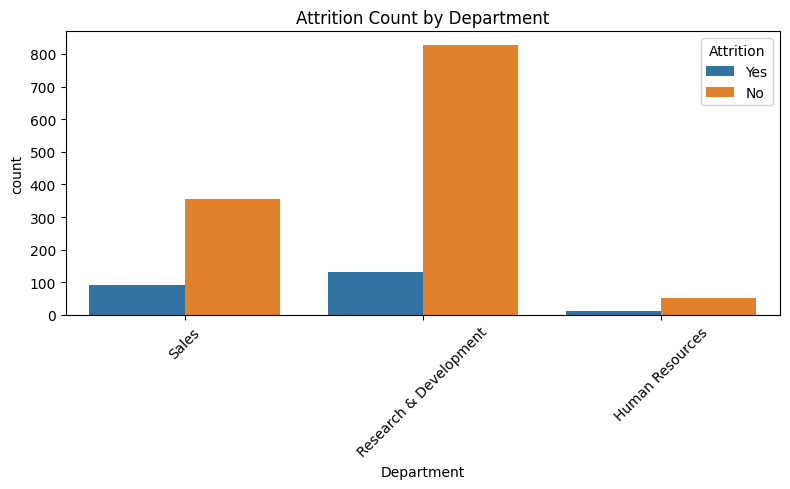

In [39]:
# Department-wise attrition
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Department', hue='Attrition')
plt.title('Attrition Count by Department')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

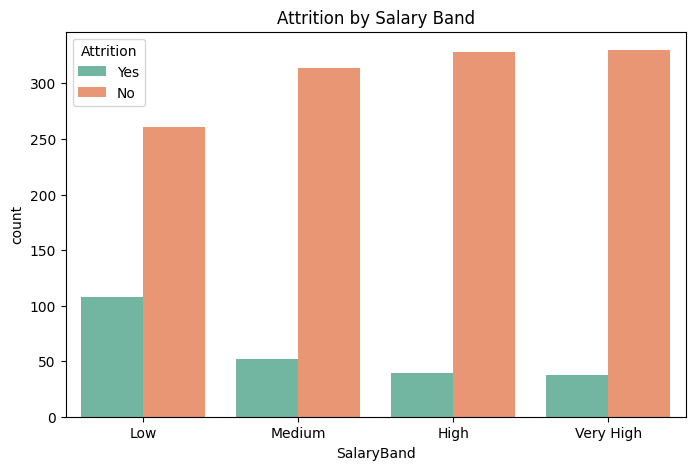

In [40]:
# Salary band (assuming MonthlyIncome is used)
df['SalaryBand'] = pd.qcut(df['MonthlyIncome'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='SalaryBand', hue='Attrition', palette='Set2')
plt.title('Attrition by Salary Band')
plt.show()

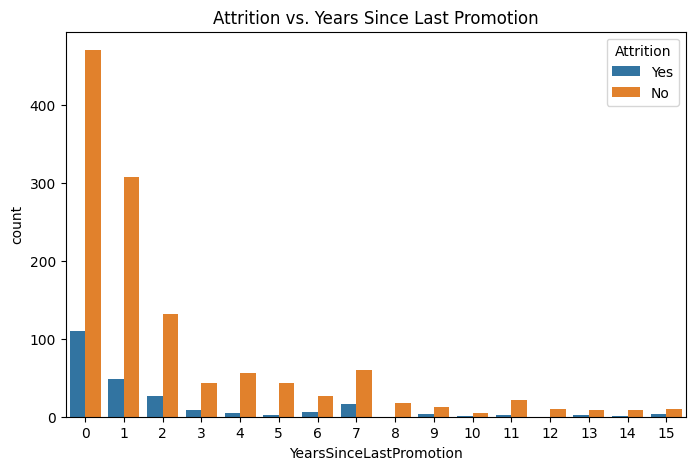

In [41]:
# Promotion analysis
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='YearsSinceLastPromotion', hue='Attrition')
plt.title('Attrition vs. Years Since Last Promotion')
plt.show()

### Data Preprocessing for Model Building

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Drop irrelevant columns
df.drop(['EmployeeNumber', 'Over18', 'StandardHours', 'EmployeeCount'], axis=1, inplace=True, errors='ignore')

# Encode categorical variables
label_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Convert SalaryBand to numeric labels
if 'SalaryBand' in df.columns:
    df['SalaryBand'] = df['SalaryBand'].astype(str)  # Ensure it's string
    df['SalaryBand'] = le.fit_transform(df['SalaryBand'])

# Features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Building & Evaluation

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# Evaluate both models
evaluate_model("Logistic Regression", y_test, log_preds)
evaluate_model("Decision Tree", y_test, tree_preds)



Logistic Regression Evaluation:
Accuracy: 0.8775510204081632
Confusion Matrix:
 [[246   1]
 [ 35  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93       247
           1       0.92      0.26      0.40        47

    accuracy                           0.88       294
   macro avg       0.90      0.63      0.67       294
weighted avg       0.88      0.88      0.85       294


Decision Tree Evaluation:
Accuracy: 0.7993197278911565
Confusion Matrix:
 [[220  27]
 [ 32  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       247
           1       0.36      0.32      0.34        47

    accuracy                           0.80       294
   macro avg       0.62      0.60      0.61       294
weighted avg       0.79      0.80      0.79       294



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SHAP Analysis

In [44]:
pip install shap

In [45]:
pip install numpy==1.24.4

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset again after runtime reset
df = pd.read_csv('/content/drive/My Drive/Machine_Learning_Lab/HR-Employee-Attrition.csv')

# Drop irrelevant columns
df.drop(['EmployeeNumber', 'Over18', 'StandardHours', 'EmployeeCount'], axis=1, inplace=True, errors='ignore')

# Encode categorical variables
le = LabelEncoder()
label_cols = df.select_dtypes(include='object').columns
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# OPTIONAL: Drop SalaryBand if still present from EDA
df.drop(['SalaryBand'], axis=1, inplace=True, errors='ignore')

# Split into features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [47]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [48]:
pip install shap

In [49]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [50]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

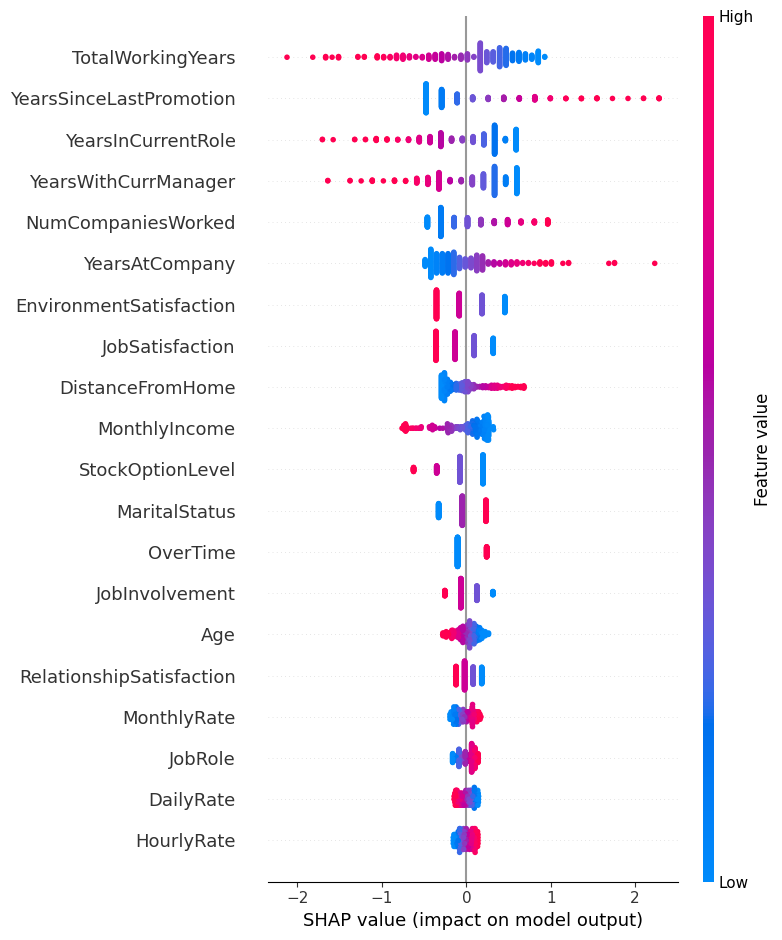

In [51]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)